In [36]:
import pandas as pd
import helper_data_load
import boto3
from sklearn.preprocessing import StandardScaler


## Test Import for Genomics Immune Ecog

In [37]:
def change_groupstr_to_id(df, col):
    df[col] = pd.Categorical(df[col])
    df[col] = df[col].cat.codes
    return df

def prep_genomics(df):
    df.set_index("Unnamed: 0", inplace=True)
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={"index":"oncotech_id"})
    return df

def make_cat_to_int(df, ecog=False):
    if ecog:
            list_clin_feats_cat = ["ecog_status"]
    else:
        list_clin_feats_cat = ["sex", "smoking_habit", "ecog_status", "first_line_io", "histology_group"]
    for col in list_clin_feats_cat:
        df_cat = change_groupstr_to_id(df, col)
    return df_cat

def data_normalization(df, scaler= StandardScaler()):
    # TRAIN
    # normalize data
    data_norm = df.copy() #Has training + test data frames combined to form single data frame
    normalizer = scaler
    df_array = normalizer.fit_transform(data_norm)
    data_norm = pd.DataFrame(data=df_array, columns=data_norm.columns)
    # rename columns because of later usage
    data_norm.columns = data_norm.columns.str.replace('.','_')
    return data_norm

In [38]:
def get_files(local, genomics=False, num_genomics=0):
    #### Accessing on Valeria
    """Accessing the S3 buckets using boto3 client"""
    s3 = boto3.resource('s3', aws_access_key_id= 'YOUR_ACCESS_KEY_ID', aws_secret_access_key='YOUR_SECRET_ACCESS_KEY')
    ENDPOINT_URL = 'https://s3.valeria.science'
    bucket = 'oncotechdata'
    if local and (genomics==False):
        pyrads_chum = pd.read_csv("../../Data/PyRads_CHUM.csv")
        pyrads_iucpq = pd.read_csv("../../Data/PyRads_IUCPQ.csv")
        clinical_chum = pd.read_csv("../../Data/clinical_CHUM.csv")
        clinical_iucpq = pd.read_csv("../../Data/clinical_IUCPQ.csv")
    elif local and genomics:
        chum_clinical = pd.read_csv("../../Data/Discovery-ClinicalData.csv")
        chum_genomics1000 = pd.read_csv("../../Data/Discovery-GenomicsTop1000-March22023.csv")
        chum_genomics5000 = pd.read_csv("../../Data/Discovery-GenomicsTop5000-March22023.csv")
        chum_genomicsImmune = pd.read_csv("../../Data/ImmuneGenesDiscovery.csv")

        iucpq_genomics = pd.read_csv("../../Data/ValidationIUCPQ-March2 2023.csv")
        iucpq_clinical = pd.read_csv("../../Data/ValidationClinicalData.csv")
    
    elif not(local) and not(genomics):
        pyrads_chum = pd.read_csv(f"s3://{bucket}/data/PyRads_CHUM.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        pyrads_iucpq = pd.read_csv(f"s3://{bucket}/data/PyRads_IUCPQ.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        clinical_chum = pd.read_csv(f"s3://{bucket}/data/clinical_CHUM.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        clinical_iucpq = pd.read_csv(f"s3://{bucket}/data/clinical_IUCPQ.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
    #### Accessing local
    elif not(local) and genomics:
        chum_clinical = pd.read_csv(f"s3://{bucket}/data/Discovery-ClinicalData.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        chum_genomics1000 = pd.read_csv(f"s3://{bucket}/data/Discovery-GenomicsTop1000-March22023.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        chum_genomics5000 = pd.read_csv(f"s3://{bucket}/data/Discovery-GenomicsTop5000-March22023.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        chum_genomicsImmune = pd.read_csv(f"s3://{bucket}/data/ImmuneGenesDiscovery.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})

        iucpq_genomics = pd.read_csv(f"s3://{bucket}/data/ValidationIUCPQ-March2 2023.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})
        iucpq_clinical = pd.read_csv(f"s3://{bucket}/data/ValidationClinicalData.csv", storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})

    if not(genomics):
        pyrads_chum.drop(columns="Unnamed: 0", inplace=True)
        pyrads_iucpq.drop(columns="Unnamed: 0", inplace=True)
        clinical_chum.drop(columns="Unnamed: 0", inplace=True)
        clinical_iucpq.drop(columns="Unnamed: 0", inplace=True)

        chum = (clinical_chum, pyrads_chum)
        iucpq = (clinical_iucpq, pyrads_iucpq)
        return chum, iucpq

    elif genomics:
        iucpq_genomics_prep = prep_genomics(iucpq_genomics)
        if num_genomics == 1000:
            chum_genomics_prep = prep_genomics(chum_genomics1000)
        elif num_genomics == 5000:
            chum_genomics_prep = prep_genomics(chum_genomics5000)
        elif num_genomics == "Immune":
            chum_genomics_prep = prep_genomics(chum_genomicsImmune)

    chum = (chum_clinical, chum_genomics_prep)
    iucpq = (iucpq_clinical, iucpq_genomics_prep)
    return chum, iucpq


def get_norm_data(local, predictor, classification=False, univar=False, ecog=False, genomics=False, num_genomics=0):
    chum, iucpq = get_files(local, genomics, num_genomics)
    chum_clinical, chum_features = chum
    iucpq_clinical, iucpq_features = iucpq

    if univar:
        list_clin_feats = ["age", "smoking_habit", "ecog_status","sex", "first_line_io", "histology_group"]
        ## CHUM
        # merge clinical data to radiation data
        # left merge removes the patients with an undefined os_days
        chum_merge = chum_features.merge(chum_clinical[["oncotech_id",predictor]+list_clin_feats],how="left", on="oncotech_id")
        print("{} patients with clinical and radiation data for CHUM.".format(len(chum_merge)))
        chum_merge.drop(columns="oncotech_id", inplace=True)
        chum_merge = make_cat_to_int(chum_merge)

        ## IUCPQ
        # merge clinical data to radiation data
        iucpq_merge = iucpq_features.merge(iucpq_clinical[["oncotech_id",predictor]+list_clin_feats],how="inner", on="oncotech_id")
        print("{} patients with clinical and radiation data for IUCPQ.".format(len(iucpq_merge)))
        iucpq_merge.drop(columns="oncotech_id", inplace=True)
        iucpq_merge = make_cat_to_int(iucpq_merge)

    elif ecog:
        list_clin_feats = ["ecog_status"]
        ## CHUM
        # merge clinical data to radiation data
        # left merge removes the patients with an undefined os_days
        chum_merge = chum_features.merge(chum_clinical[["oncotech_id",predictor]+list_clin_feats],how="left", on="oncotech_id")
        print("{} patients with clinical and radiation data for CHUM.".format(len(chum_merge)))
        chum_merge.drop(columns="oncotech_id", inplace=True)
        # remove values of nan values
        chum_merge_pdl_rem = chum_merge.dropna(axis=0, subset = list_clin_feats)
        print("{} patients with predictor {} and ecog data for CHUM.".format(len(chum_merge_pdl_rem), predictor))
        chum_merge_pdl_rem = make_cat_to_int(chum_merge_pdl_rem, ecog=True)
        chum_merge = chum_merge_pdl_rem.copy()

        ## IUCPQ
        # merge clinical data to radiation data
        # left merge removes the patients with an undefined os_days
        iucpq_merge = iucpq_features.merge(iucpq_clinical[["oncotech_id",predictor]+list_clin_feats],how="left", on="oncotech_id")
        print("{} patients with clinical and radiation data for IUCPQ.".format(len(iucpq_merge)))
        # remove values of nan values
        iucpq_merge_pdl_rem = iucpq_merge.dropna(axis=0, subset=["ecog_status"])
        print("{} patients with os, radiation, ecog and pdl1 data for IUCPQ.".format(len(iucpq_merge_pdl_rem)))
        iucpq_merge_pdl_rem.drop(columns="oncotech_id", inplace=True)
        iucpq_merge_pdl_rem = make_cat_to_int(iucpq_merge_pdl_rem, ecog=True)
        iucpq_merge = iucpq_merge_pdl_rem.copy()

    else:
        ## CHUM
        # merge clinical data to radiation data
        # left merge removes the patients with an undefined os_days
        chum_merge = chum_features.merge(chum_clinical[["oncotech_id",predictor]],how="left", on="oncotech_id")
        print("{} patients with clinical and radiation data for CHUM.".format(len(chum_merge)))
        chum_merge.drop(columns="oncotech_id", inplace=True)

        ## IUCPQ
        # merge clinical data to radiation data
        iucpq_merge = iucpq_features.merge(iucpq_clinical[["oncotech_id",predictor]],how="inner", on="oncotech_id")
        print("{} patients with clinical and radiation data for IUCPQ.".format(len(iucpq_merge)))
        iucpq_merge.drop(columns="oncotech_id", inplace=True)
    

    data_norm_chum = data_normalization(chum_merge)
    data_norm_iucpq = data_normalization(iucpq_merge)

    data_norm_chum.dropna(axis=0, subset=predictor, inplace=True)
    data_norm_iucpq.dropna(axis=0, subset=predictor, inplace=True)
    print("{} patients after drop NaN - CHUM.".format(len(data_norm_chum)))
    print("{} patients after drop NaN - IUCPQ.".format(len(data_norm_iucpq)))
    data_norm_chum.reset_index(inplace=True, drop=True)
    data_norm_iucpq.reset_index(inplace=True, drop=True)

    genes_not_in_vali = list(set(data_norm_chum.columns)- set(data_norm_iucpq.columns))
    data_norm_chum = data_norm_chum.drop(columns=genes_not_in_vali)

    if classification:
        data_norm_chum_class = add_os_day_class(data_norm_chum, predictor)
        print("{} patients with clinical and radiation data for CHUM and classification.".format(len(data_norm_chum_class)))
        data_norm_iucpq_class = add_os_day_class(data_norm_iucpq, predictor)
        print("{} patients with clinical and radiation data for IUCPQ and classification.".format(len(data_norm_iucpq_class)))

        return data_norm_chum_class, data_norm_iucpq_class

    return data_norm_chum, data_norm_iucpq

In [46]:
local = True
genomics = True
num_genomics = 5000
predictor = "os_days"
classification=False
univar=False
ecog=True
chum, iucpq = get_norm_data(local, predictor, classification, univar, ecog, genomics, num_genomics)
#chum, iucpq = get_files(local, genomics, num_genomics)
#chum_clinical, chum_features = chum
#iucpq_clinical, iucpq_features = iucpq

72 patients with clinical and radiation data for CHUM.
72 patients with predictor os_days and ecog data for CHUM.
59 patients with clinical and radiation data for IUCPQ.
58 patients with os, radiation, ecog and pdl1 data for IUCPQ.


/var/folders/km/l90xp47s19v3fplyb1b0bc480000gp/T/ipykernel_42616/4209808510.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iucpq_merge_pdl_rem.drop(columns="oncotech_id", inplace=True)
/var/folders/km/l90xp47s19v3fplyb1b0bc480000gp/T/ipykernel_42616/121963099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.Categorical(df[col])
/var/folders/km/l90xp47s19v3fplyb1b0bc480000gp/T/ipykernel_42616/121963099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

72 patients after drop NaN - CHUM.
58 patients after drop NaN - IUCPQ.


/var/folders/km/l90xp47s19v3fplyb1b0bc480000gp/T/ipykernel_42616/121963099.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_norm.columns = data_norm.columns.str.replace('.','_')


In [49]:
iucpq

,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,os_days,ecog_status
0,-0.425977,-2.552780,-1.503008,-1.176048,0.429782,-0.398961,-1.494847,-0.017401,1.144078,-1.315053,...,-1.478428,-0.492908,-2.763983,-0.396798,-1.058985,-1.760356,-2.246542,-0.436118,-1.430265,0.263635
1,0.035960,-1.964546,-1.142929,-0.315917,-2.959014,-0.398961,-0.822992,0.393123,-0.374556,0.566863,...,-0.837152,-0.071078,-1.094022,-2.514311,0.379577,-2.127072,-2.451054,0.237406,-1.285132,0.263635
2,-1.296116,-2.310554,-1.090800,-1.176048,-0.301263,-1.369493,-2.242439,0.345802,-0.757052,-0.182154,...,-1.118268,-0.551360,-2.307397,0.796758,-1.055496,-2.620397,-2.053428,1.969948,-0.610964,0.263635
3,-0.245236,-0.901649,-0.382961,0.544214,-0.949941,-0.398961,0.415215,-2.213229,0.396401,-2.091514,...,-1.278404,-0.683536,0.627342,0.863466,0.393921,0.386659,0.305356,-0.130968,1.250019,-1.920771
4,-0.107417,-1.340850,-0.279672,0.821114,-1.962069,1.355135,-3.555568,-0.673635,-0.374556,-1.307193,...,0.498565,-0.535783,0.337849,-0.059758,-0.875819,-0.371834,-0.208688,-0.947809,-1.378766,0.263635
5,-0.069537,-0.915014,0.001765,-1.176048,-0.600652,-1.369493,-0.117663,-2.213229,-1.060655,-1.861648,...,0.505117,-0.025337,0.306237,0.126562,-2.039835,-0.880004,0.253840,-0.754516,-1.275768,0.263635
6,-0.350017,-1.645826,-0.684105,-1.176048,-1.670481,-1.369493,-0.930031,-0.466219,-0.541642,-0.142033,...,-0.617849,1.651591,-2.411866,0.644204,0.393633,-2.560801,-1.726253,1.542651,0.901231,0.263635
7,2.297311,-0.722017,0.821603,-1.176048,1.361382,0.168764,0.986136,-2.213229,1.124109,0.268567,...,-1.272076,0.943969,0.292181,-0.350270,0.140317,0.202691,0.115328,0.676343,-1.266405,0.263635
8,-0.407114,0.651465,-0.644682,-1.176048,-0.615973,-1.369493,-0.390096,0.396162,-0.757052,0.550804,...,-0.029360,1.550371,-0.817810,0.174703,1.735759,-1.649322,-0.690468,0.732473,-1.441969,2.448042
9,0.114419,0.655682,0.657014,-1.176048,-0.059372,0.571571,-1.432009,-0.535918,-0.022628,-0.010003,...,-0.082494,-0.384726,-1.023795,0.002475,0.795459,-0.783012,-0.904347,1.142275,-1.390471,0.263635


In [48]:
iucpq_features.columns

Index(['oncotech_id', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='Unnamed: 0', length=17561)

In [33]:
chum_features.columns

Index(['oncotech_id', 'PRKRA', 'DDX3X', 'DDX58', 'IL1A', 'IFIH1', 'EFTUD2',
       'IRF3', 'TRAF6', 'MAVS',
       ...
       'PRKCE', 'STAT5B', 'STAT5A', 'SOCS5', 'REL', 'RPS6KA4', 'SH2D1A',
       'SLAMF8', 'SLAMF6', 'SLAMF7'],
      dtype='object', name='Unnamed: 0', length=897)

In [ ]:
chum, iucpq = helper_data_load.get_norm_data(local=True, predictor="os_days", genomics=True, num_genomics="Immune", ecog=True)

UnboundLocalError: local variable 'pyrads_chum' referenced before assignment

In [2]:
df_temp = pd.read_csv("../../Data/ImmuneGenesDiscovery.csv")

In [3]:
df_temp

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
0,PRKRA,1.748624,1.667645,3.033686,2.660120,4.736283,2.374625,4.694872,3.573849,5.223417,...,3.890708,4.451507,3.930180,4.373705,3.674166,1.542757,4.546985,2.882748,4.262156,4.292199
1,DDX3X,5.532137,4.961447,6.118060,5.963877,6.920708,5.313249,7.212228,6.542956,6.951881,...,5.824003,6.049111,5.594509,6.499197,6.010801,6.287528,6.507648,4.001511,7.081508,7.505832
2,DDX58,4.534227,5.036218,4.573628,5.058595,6.118071,4.701635,6.311325,5.039760,5.461386,...,5.669469,5.377086,5.481468,6.360903,5.609304,4.807853,5.163897,4.749435,5.978746,5.981240
3,IL1A,2.397895,0.693147,2.079442,2.302585,2.639057,1.098612,5.416100,2.833213,5.117994,...,2.397895,1.386294,1.791759,2.772589,1.609438,2.197225,2.944439,0.000000,2.302585,3.258097
4,IFIH1,3.715681,4.110874,4.851185,4.622391,5.814545,2.790550,6.185475,4.532599,5.238776,...,5.370096,5.068539,5.138513,5.167201,3.531807,4.156275,4.783919,4.682131,5.262672,5.552543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,RPS6KA4,3.712468,4.024454,5.933363,4.511570,5.877628,2.544245,5.506251,4.911301,6.536138,...,4.457867,4.728749,4.830616,4.792773,5.356793,4.262135,5.045976,4.022858,4.943917,5.453288
892,SH2D1A,2.697539,2.412876,0.000000,3.307465,3.598196,2.990278,2.484907,0.000000,0.000000,...,1.791759,3.555348,0.000000,2.935074,0.000000,2.359377,0.000000,2.755753,4.692843,3.064197
893,SLAMF8,3.307816,3.227548,3.830834,4.458829,5.446452,3.043186,4.141335,3.147925,4.221279,...,5.035456,4.794773,3.612348,4.954841,0.000000,4.126493,2.071409,4.286869,3.990255,5.055268
894,SLAMF6,3.652403,3.700723,3.286219,4.254213,4.838113,3.699074,3.674244,3.366771,3.984219,...,3.378270,4.083435,4.009158,4.349703,3.137750,4.284577,3.744542,4.751558,5.867766,4.764980


In [4]:
chum, iucpq = helper_data_load.get_norm_data(local=True, predictor="os_days", genomics=True, num_genomics="Immune")

72 patients with clinical and genomics (1000) data for CHUM.
72 patients with clinical and genomics (5000) data for CHUM.
72 patients with clinical and genomics (Immune) data for CHUM.
59 patients with clinical and genomics data for IUCPQ.


/Users/iucpq/Documents/IUCPQ/IUCPQ/Predictions/helper_data_load.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_norm.columns = data_norm.columns.str.replace('.','_')


72 patients after drop NaN - CHUM.
59 patients after drop NaN - IUCPQ.


/Users/iucpq/Documents/IUCPQ/IUCPQ/Predictions/helper_data_load.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_norm.columns = data_norm.columns.str.replace('.','_')


In [7]:
chum

,PRKRA,DDX3X,DDX58,IL1A,IFIH1,EFTUD2,IRF3,TRAF6,MAVS,IKBKB,...,STAT5B,STAT5A,SOCS5,REL,RPS6KA4,SH2D1A,SLAMF8,SLAMF6,SLAMF7,os_days
0,-2.207301,-0.709704,-1.572375,0.002464,-1.532078,-1.499309,-0.760127,-1.478189,1.253447,0.288019,...,-0.933015,-1.055825,-0.271877,-1.347412,-1.543546,0.452180,-0.748042,-0.726875,-0.207563,1.660906
1,-2.307943,-1.495450,-0.614344,-1.607581,-0.955316,-1.905325,-2.011164,-3.000039,-1.307719,-1.620914,...,-1.463970,-1.025565,-1.280964,-0.607441,-1.075051,0.270897,-0.831911,-0.657385,-0.382825,-0.209528
2,-0.610205,0.097015,-1.497179,-0.298299,0.125128,1.176774,1.409827,-1.437790,1.498855,-0.073092,...,0.071597,-0.031158,-1.657823,-2.235817,1.791464,-1.265708,-0.201558,-1.253481,0.159705,1.332598
3,-1.074478,-0.115269,-0.571638,-0.087551,-0.208785,-1.332597,-0.723463,-0.486696,1.429743,0.392883,...,0.365164,-0.273160,-0.468013,-0.380836,-0.343573,0.840602,0.454613,0.138586,-0.014937,-0.859209
4,1.505811,1.202129,1.450331,0.230229,1.531099,1.224116,1.237987,1.683672,0.104298,1.489283,...,1.561161,1.575209,2.401847,0.648439,1.707770,1.025750,1.486546,0.978289,0.530293,-0.493908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-2.463156,0.330345,-1.050169,-0.187059,-0.889055,-1.439957,-0.864665,-0.688961,1.770324,0.526442,...,0.052301,-0.228749,-0.201343,0.006339,-0.718138,0.236826,0.107365,0.182252,-0.246742,-0.380618
68,1.270548,0.633414,-0.370673,0.518646,0.026956,1.439956,0.642759,1.125328,0.125924,0.643113,...,0.057657,-0.165426,0.025078,0.994239,0.458918,-1.265708,-2.039922,-0.594370,-1.294729,-0.151727
69,-0.797793,-2.817123,-1.161658,-2.262222,-0.121597,-0.658816,0.860612,-0.763861,-0.827991,0.040232,...,-0.048740,0.969582,-1.902567,-0.815681,-1.077448,0.489252,0.274937,0.853815,0.837020,-0.045374
70,0.916559,1.423524,1.184434,-0.087551,0.725671,1.424472,1.301581,1.595091,0.332962,1.441272,...,2.478679,1.888691,1.000864,1.783457,0.305661,1.722860,-0.034985,2.459028,0.540510,-0.059246


In [6]:
genes_not_in_vali = list(set(chum.columns)- set(iucpq.columns))
genes_not_in_vali

[]

In [6]:
genes_not_in_vali = list(set(chum.columns)- set(iucpq.columns))
chum_drop = chum.drop(columns=genes_not_in_vali)

In [7]:
genes_not_in_vali = list(set(chum_drop.columns)- set(iucpq.columns))


In [8]:
chum_disc_clinical = pd.read_csv("../../Data/Discovery-ClinicalData.csv")
chum_disc_genomics1000 = pd.read_csv("../../Data/Discovery-GenomicsTop1000.csv")
chum_disc_genomics5000 = pd.read_csv("../../Data/Discovery-GenomicsTop5000.csv")

chum_disc_genomics1000new = pd.read_csv("../../Data/Discovery-GenomicsTop1000-March22023.csv")
chum_disc_genomics5000new = pd.read_csv("../../Data/Discovery-GenomicsTop5000-March22023.csv")

iucpq_vali_genomics = pd.read_csv("../../Data/ValidationIUCPQ.csv")
iucpq_vali_genomicsnew = pd.read_csv("../../Data/ValidationIUCPQ-March2 2023.csv")
iucpq_vali_clinical = pd.read_csv("../../Data/ValidationClinicalData.csv")

In [9]:
def prep_genomics(df):
    df.set_index("Unnamed: 0", inplace=True)
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={"index":"oncotech_id"})
    return df
#iucpq_vali_genomics.rename(columns={"Unnamed: 0":"oncotech_id"}, inplace=True)
chum_disc_genomics1000_prep = prep_genomics(chum_disc_genomics1000)
iucpq_vali_genomicsnew_prep = prep_genomics(iucpq_vali_genomicsnew)

In [10]:
iucpq_vali_genomicsnew_prep

Unnamed: 0,oncotech_id,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,038-IUCPQ,2.729731,4.268267,2.413743,0.000000,4.712263,0.693147,2.197271,3.118150,3.637586,...,3.555397,4.266105,3.156000,4.297605,3.385033,3.812556,5.697433,3.873007,4.857259,4.929202
1,041-IUCPQ,3.145681,4.936786,2.757067,0.693147,0.000000,0.693147,2.913647,3.701106,1.609438,...,3.330839,1.333903,3.431536,4.489489,4.477706,2.658153,6.108572,3.558536,4.736808,5.288773
2,046-IUCPQ,1.946216,4.543553,2.806771,0.000000,3.695714,0.000000,1.400141,3.633909,1.098612,...,4.249206,3.475542,3.310749,4.271016,3.683782,4.463247,5.698430,3.135494,4.970997,6.213718
3,017-IUCPQ,2.892479,6.144752,3.481676,1.386294,2.793700,0.693147,4.233902,0.000000,2.639057,...,4.797026,4.320458,3.241944,4.210891,5.604014,4.499614,6.112671,5.714141,6.360240,5.092111
4,019-IUCPQ,3.016577,5.645607,3.580160,1.609438,1.386294,1.945910,0.000000,2.186275,1.609438,...,3.311464,0.000000,4.005450,4.278102,5.414596,3.996301,5.749781,5.063708,6.057486,4.656028
5,049-IUCPQ,3.050687,6.129563,3.848502,0.000000,3.279401,0.000000,3.665713,0.000000,0.693147,...,3.186225,2.134145,4.008265,4.510296,5.393911,4.097877,5.417107,4.627937,6.329899,4.759221
6,021-IUCPQ,2.798128,5.299006,3.194544,0.000000,1.791759,0.000000,2.799515,2.480812,1.386294,...,4.584662,3.850583,3.525763,5.273104,3.615427,4.380079,6.112589,3.186600,5.163691,5.985598
7,024-IUCPQ,5.181909,6.348901,4.630194,0.000000,6.007691,1.098612,4.842653,0.000000,3.610918,...,4.376388,4.249134,3.244663,4.951217,5.384714,3.837922,6.040192,5.556382,6.248320,5.523107
8,050-IUCPQ,2.746715,7.909843,3.232132,0.000000,3.258097,0.000000,3.375228,3.705423,1.098612,...,4.167073,3.196190,3.778618,5.227060,4.658435,4.124122,6.496167,3.968222,5.773733,5.553072
9,025-IUCPQ,3.216329,7.914635,4.473264,0.000000,4.032074,1.386294,2.264274,2.381838,2.079442,...,4.715541,3.141273,3.755788,4.346815,4.523657,4.030228,6.227430,4.711111,5.647766,5.771852


In [19]:
chum_disc_genomics1000.sort_values("Unnamed: 0")

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
862,A2M,7.762106,7.872027,7.017131,8.234607,8.816095,7.030696,7.157918,5.685109,6.836658,...,6.484203,8.140912,5.953059,7.171532,3.471213,8.712262,5.440608e+00,5.911881,6.252301,6.203914
767,AACS,0.000000,0.000000,3.703615,0.000000,3.886890,0.000000,4.914932,3.143675,5.248356,...,3.331766,3.410808,3.425063,5.298544,3.267940,2.223342,5.489643e+00,1.723353,3.107377,5.333395
425,AARSD1,0.000000,0.000001,3.541796,2.386767,2.069449,0.000000,3.492597,2.907477,3.399755,...,0.000000,0.000000,2.598095,1.590684,2.446504,0.000000,1.925611e+00,2.708337,0.000000,2.174036
449,ABCA10,1.016151,2.202627,0.693147,1.098612,3.481678,2.291367,1.098612,0.000000,0.000000,...,0.000000,1.098612,2.409880,2.952314,0.000000,1.386294,3.085454e+00,0.000000,0.000000,0.000000
677,ABCA13,5.047896,3.529701,3.173566,3.620692,3.593384,3.893786,5.445035,6.424038,5.239600,...,4.294088,6.812460,5.993689,6.725330,8.073501,4.758921,8.293413e+00,2.590081,5.316089,4.687587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,ZNF385B,3.803621,2.089183,3.258088,3.279843,1.386294,2.698160,0.693147,1.611265,1.386294,...,1.386294,0.759760,3.785394,0.693147,0.000000,3.322345,6.931472e-01,1.386294,1.566402,3.829054
226,ZNF519,0.000000,0.000000,0.000000,0.000000,3.485826,0.000000,0.000000,0.000000,0.000000,...,3.393018,0.000000,3.569505,2.926048,0.890923,0.000000,3.420574e+00,3.207919,3.024820,0.000000
203,ZNF709,1.243819,3.202792,0.000000,0.000000,3.591916,2.581069,0.000000,1.532346,3.091986,...,2.510985,2.822194,0.000000,0.000000,0.795130,0.000000,3.328344e+00,3.316457,3.684119,2.639893
301,ZNF74,2.968832,0.000000,3.315544,1.713682,2.631215,2.517879,0.462674,2.602289,0.000000,...,2.649394,1.463057,2.676187,0.000000,3.397337,0.000000,4.852797e-08,1.880575,0.000000,3.099213


In [24]:
chum_disc_genomics1000new.sort_values("Unnamed: 0")

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
854,A2M,7.762106,7.872027,7.017131,8.234607,8.816095,7.030696,7.157918,5.685109,6.836658,...,6.484203,8.140912,5.953059,7.171532,3.471213,8.712262,5.440608e+00,5.911881,6.252301,6.203914
760,AACS,0.000000,0.000000,3.703615,0.000000,3.886890,0.000000,4.914932,3.143675,5.248356,...,3.331766,3.410808,3.425063,5.298544,3.267940,2.223342,5.489643e+00,1.723353,3.107377,5.333395
423,AARSD1,0.000000,0.000001,3.541796,2.386767,2.069449,0.000000,3.492597,2.907477,3.399755,...,0.000000,0.000000,2.598095,1.590684,2.446504,0.000000,1.925611e+00,2.708337,0.000000,2.174036
446,ABCA10,1.016151,2.202627,0.693147,1.098612,3.481678,2.291367,1.098612,0.000000,0.000000,...,0.000000,1.098612,2.409880,2.952314,0.000000,1.386294,3.085454e+00,0.000000,0.000000,0.000000
673,ABCA13,5.047896,3.529701,3.173566,3.620692,3.593384,3.893786,5.445035,6.424038,5.239600,...,4.294088,6.812460,5.993689,6.725330,8.073501,4.758921,8.293413e+00,2.590081,5.316089,4.687587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,ZNF385B,3.803621,2.089183,3.258088,3.279843,1.386294,2.698160,0.693147,1.611265,1.386294,...,1.386294,0.759760,3.785394,0.693147,0.000000,3.322345,6.931472e-01,1.386294,1.566402,3.829054
225,ZNF519,0.000000,0.000000,0.000000,0.000000,3.485826,0.000000,0.000000,0.000000,0.000000,...,3.393018,0.000000,3.569505,2.926048,0.890923,0.000000,3.420574e+00,3.207919,3.024820,0.000000
203,ZNF709,1.243819,3.202792,0.000000,0.000000,3.591916,2.581069,0.000000,1.532346,3.091986,...,2.510985,2.822194,0.000000,0.000000,0.795130,0.000000,3.328344e+00,3.316457,3.684119,2.639893
300,ZNF74,2.968832,0.000000,3.315544,1.713682,2.631215,2.517879,0.462674,2.602289,0.000000,...,2.649394,1.463057,2.676187,0.000000,3.397337,0.000000,4.852797e-08,1.880575,0.000000,3.099213


In [23]:
chum_disc_genomics1000new.isna().any().any()

False

In [25]:
chum_disc_genomics1000  = chum_disc_genomics1000.sort_values("Unnamed: 0")
chum_disc_genomics1000new = chum_disc_genomics1000new.sort_values("Unnamed: 0")


In [28]:
chum_disc_genomics1000[~chum_disc_genomics1000.apply(tuple,1).isin(chum_disc_genomics1000new.apply(tuple,1))]

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
831,AC002996.1,0.000000,0.000000,0.000000,0.0,2.359724,0.00000,0.000000,0.000000,3.483566,...,0.000000,3.465492,0.000000,3.712409,0.000000,0.0,4.000579e+00,0.000000,3.005947,3.561760
356,AC008982.1,0.000000,0.000000,3.372124,0.0,1.888262,0.00000,1.732271,0.000000,2.496714,...,0.000000,3.202872,2.589120,3.438303,0.000000,0.0,2.111185e+00,3.245593,3.054849,2.687377
760,AC063943.3,0.000000,0.912374,0.000000,0.0,2.051649,0.00000,0.000000,0.918245,2.447070,...,1.670855,0.952924,2.587309,0.000000,1.778929,0.0,1.744175e+00,2.414855,2.064283,3.289375
674,AL132780.3,0.000000,2.443905,0.000000,0.0,1.988911,1.71251,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.855448,0.000000,0.0,2.107806e+00,0.691386,0.000000,1.975982
728,F8A2,0.000000,0.000000,2.222282,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,3.734599,3.837124,3.450117,0.000000,0.0,4.028271e+00,4.042131,3.556465,4.658406
209,MAGEA3,3.209241,0.000000,0.000000,0.0,4.101359,0.00000,0.000000,5.358117,4.857271,...,3.878702,0.000000,0.000000,0.000000,4.687332,0.0,1.098612e+00,0.693147,0.000000,0.693147
721,MAGEA6,3.500820,0.000000,0.000000,0.0,3.722291,0.00000,0.000000,4.962270,4.814843,...,1.729639,0.000000,0.000000,0.000000,4.901095,0.0,5.036700e-07,0.000000,0.000000,0.000000
431,TBC1D3I,0.000000,0.000000,2.446384,0.0,0.000000,0.00000,2.914724,2.138832,2.398998,...,0.000000,0.740631,2.627408,0.016486,1.946967,0.0,3.529229e+00,0.000000,0.007397,2.181020


In [45]:
iucpq_vali_genomicsnew.isna().any()

Unnamed: 0    False
038-IUCPQ     False
041-IUCPQ     False
046-IUCPQ     False
017-IUCPQ     False
019-IUCPQ     False
049-IUCPQ     False
021-IUCPQ     False
024-IUCPQ     False
050-IUCPQ     False
025-IUCPQ     False
026-IUCPQ     False
051-IUCPQ     False
052-IUCPQ     False
053-IUCPQ     False
027-IUCPQ     False
028-IUCPQ     False
056-IUCPQ     False
029-IUCPQ     False
058-IUCPQ     False
030-IUCPQ     False
059-IUCPQ     False
060-IUCPQ     False
063-IUCPQ     False
079-IUCPQ     False
086-IUCPQ     False
092-IUCPQ     False
094-IUCPQ     False
098-IUCPQ     False
099-IUCPQ     False
100-IUCPQ     False
103-IUCPQ     False
105-IUCPQ     False
106-IUCPQ     False
107-IUCPQ     False
115-IUCPQ     False
117-IUCPQ     False
123-IUCPQ     False
129-IUCPQ     False
130-IUCPQ     False
131-IUCPQ     False
133-IUCPQ     False
134-IUCPQ     False
136-IUCPQ     False
137-IUCPQ     False
139-IUCPQ     False
140-IUCPQ     False
143-IUCPQ     False
144-IUCPQ     False
145-IUCPQ     False


In [47]:
genes_1000 = chum_disc_genomics1000["Unnamed: 0"].tolist()
genes_1000new = chum_disc_genomics1000new["Unnamed: 0"].tolist()
genes_5000new = chum_disc_genomics5000new["Unnamed: 0"].tolist()
iucpq_genes = iucpq_vali_genomicsnew["Unnamed: 0"].tolist()

In [48]:
genes_1000 == genes_1000new

False

In [49]:
#print("Not in CHUM: ", list(set(iucpq_genes) - set(genes_1000new)))
print("Not in IUCPQ", list(set(genes_1000new) - set(iucpq_genes)))
print("Not in IUCPQ", list(set(genes_5000new) - set(iucpq_genes)))

Not in IUCPQ []
Not in IUCPQ []


In [35]:
print("Not in new: ", list(set(genes_1000) - set(genes_1000new)))
print("Not in old", list(set(genes_1000new) - set(genes_1000)))

Not in new:  ['MAGEA6', 'AC002996.1', 'AC063943.3', 'F8A2', 'AC008982.1', 'MAGEA3', 'TBC1D3I', 'AL132780.3']
Not in old ['ACE2', 'FBN2', 'CDO1', 'AC008878.3', 'CCDC13', 'ADAMTS5', 'CTAGE6', 'BNC1']


In [26]:
chum_disc_genomics1000

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
862,A2M,7.762106,7.872027,7.017131,8.234607,8.816095,7.030696,7.157918,5.685109,6.836658,...,6.484203,8.140912,5.953059,7.171532,3.471213,8.712262,5.440608e+00,5.911881,6.252301,6.203914
767,AACS,0.000000,0.000000,3.703615,0.000000,3.886890,0.000000,4.914932,3.143675,5.248356,...,3.331766,3.410808,3.425063,5.298544,3.267940,2.223342,5.489643e+00,1.723353,3.107377,5.333395
425,AARSD1,0.000000,0.000001,3.541796,2.386767,2.069449,0.000000,3.492597,2.907477,3.399755,...,0.000000,0.000000,2.598095,1.590684,2.446504,0.000000,1.925611e+00,2.708337,0.000000,2.174036
449,ABCA10,1.016151,2.202627,0.693147,1.098612,3.481678,2.291367,1.098612,0.000000,0.000000,...,0.000000,1.098612,2.409880,2.952314,0.000000,1.386294,3.085454e+00,0.000000,0.000000,0.000000
677,ABCA13,5.047896,3.529701,3.173566,3.620692,3.593384,3.893786,5.445035,6.424038,5.239600,...,4.294088,6.812460,5.993689,6.725330,8.073501,4.758921,8.293413e+00,2.590081,5.316089,4.687587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,ZNF385B,3.803621,2.089183,3.258088,3.279843,1.386294,2.698160,0.693147,1.611265,1.386294,...,1.386294,0.759760,3.785394,0.693147,0.000000,3.322345,6.931472e-01,1.386294,1.566402,3.829054
226,ZNF519,0.000000,0.000000,0.000000,0.000000,3.485826,0.000000,0.000000,0.000000,0.000000,...,3.393018,0.000000,3.569505,2.926048,0.890923,0.000000,3.420574e+00,3.207919,3.024820,0.000000
203,ZNF709,1.243819,3.202792,0.000000,0.000000,3.591916,2.581069,0.000000,1.532346,3.091986,...,2.510985,2.822194,0.000000,0.000000,0.795130,0.000000,3.328344e+00,3.316457,3.684119,2.639893
301,ZNF74,2.968832,0.000000,3.315544,1.713682,2.631215,2.517879,0.462674,2.602289,0.000000,...,2.649394,1.463057,2.676187,0.000000,3.397337,0.000000,4.852797e-08,1.880575,0.000000,3.099213


In [27]:
chum_disc_genomics1000new

,Unnamed: 0,001-CHUM,002-CHUM,003-CHUM,004-CHUM,006-CHUM,012-CHUM,013-CHUM,017-CHUM,018-CHUM,...,210-CHUM,217-CHUM,221-CHUM,229-CHUM,235-CHUM,237-CHUM,238-CHUM,239-CHUM,244-CHUM,246-CHUM
854,A2M,7.762106,7.872027,7.017131,8.234607,8.816095,7.030696,7.157918,5.685109,6.836658,...,6.484203,8.140912,5.953059,7.171532,3.471213,8.712262,5.440608e+00,5.911881,6.252301,6.203914
760,AACS,0.000000,0.000000,3.703615,0.000000,3.886890,0.000000,4.914932,3.143675,5.248356,...,3.331766,3.410808,3.425063,5.298544,3.267940,2.223342,5.489643e+00,1.723353,3.107377,5.333395
423,AARSD1,0.000000,0.000001,3.541796,2.386767,2.069449,0.000000,3.492597,2.907477,3.399755,...,0.000000,0.000000,2.598095,1.590684,2.446504,0.000000,1.925611e+00,2.708337,0.000000,2.174036
446,ABCA10,1.016151,2.202627,0.693147,1.098612,3.481678,2.291367,1.098612,0.000000,0.000000,...,0.000000,1.098612,2.409880,2.952314,0.000000,1.386294,3.085454e+00,0.000000,0.000000,0.000000
673,ABCA13,5.047896,3.529701,3.173566,3.620692,3.593384,3.893786,5.445035,6.424038,5.239600,...,4.294088,6.812460,5.993689,6.725330,8.073501,4.758921,8.293413e+00,2.590081,5.316089,4.687587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,ZNF385B,3.803621,2.089183,3.258088,3.279843,1.386294,2.698160,0.693147,1.611265,1.386294,...,1.386294,0.759760,3.785394,0.693147,0.000000,3.322345,6.931472e-01,1.386294,1.566402,3.829054
225,ZNF519,0.000000,0.000000,0.000000,0.000000,3.485826,0.000000,0.000000,0.000000,0.000000,...,3.393018,0.000000,3.569505,2.926048,0.890923,0.000000,3.420574e+00,3.207919,3.024820,0.000000
203,ZNF709,1.243819,3.202792,0.000000,0.000000,3.591916,2.581069,0.000000,1.532346,3.091986,...,2.510985,2.822194,0.000000,0.000000,0.795130,0.000000,3.328344e+00,3.316457,3.684119,2.639893
300,ZNF74,2.968832,0.000000,3.315544,1.713682,2.631215,2.517879,0.462674,2.602289,0.000000,...,2.649394,1.463057,2.676187,0.000000,3.397337,0.000000,4.852797e-08,1.880575,0.000000,3.099213


In [ ]:
chum_disc_genomics1000.equals(chum_disc_genomics1000new)

In [12]:
predictor = "os_days"

In [13]:

chum_disc_genomics5000_prep = prep_genomics(chum_disc_genomics5000)

chum_merge_gen_1000 = chum_disc_genomics1000_prep.merge(chum_disc_clinical[["oncotech_id",predictor]],how="left", on="oncotech_id")
print("{} patients with clinical and genomics (1000) data for CHUM.".format(len(chum_merge_gen_1000)))
chum_merge_gen_1000.drop(columns="oncotech_id", inplace=True)

chum_merge_gen_5000 = chum_disc_genomics5000_prep.merge(chum_disc_clinical[["oncotech_id",predictor]],how="left", on="oncotech_id")
print("{} patients with clinical and genomics (5000) data for CHUM.".format(len(chum_merge_gen_5000)))
chum_merge_gen_5000.drop(columns="oncotech_id", inplace=True)

72 patients with clinical and genomics (1000) data for CHUM.
72 patients with clinical and genomics (5000) data for CHUM.


In [4]:
chum_disc_genomics5000_prep

Unnamed: 0,oncotech_id,SFTPA2,HLA-E,SFTPA1,SFTPC,HLA-DRA,USP9Y,KRT6A,HLA-C,HLA-DQB1,...,KRTAP5-8,LHFPL1,LHX5,LINC00634,LINGO2,LRRC4C,LRRTM3,LYPD2,MAFA,MAGEA4
0,001-CHUM,8.240757,0.000000e+00,8.023296,7.516791,0.000000,0.000000,6.056639,0.000000,0.000000,...,0.000000,1.098612,1.386294,0.693147,0.000000,1.791759,0.693147,0.000000,0.693147,4.189655
1,002-CHUM,7.714116,0.000000e+00,7.314890,5.224377,0.000000,0.000000,1.945910,6.728688,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.693147,1.386294,0.693147,0.693147,0.000000,0.000000
2,003-CHUM,9.012773,6.585213e+00,8.464914,5.520301,2.296657,0.000000,8.465717,0.000000,4.060341,...,1.386294,0.000000,0.000000,2.079442,0.000000,1.386294,0.000000,0.693147,0.693147,1.386294
3,004-CHUM,7.391322,4.800465e+00,7.269480,7.272068,0.000000,0.000000,0.000000,0.000000,5.418071,...,0.693147,0.693147,0.693147,1.098612,0.000000,1.609438,1.609438,0.000000,0.000000,0.000000
4,006-CHUM,0.000000,0.000000e+00,0.693147,0.000000,7.368943,6.327728,5.777786,4.220084,5.250650,...,0.000000,0.000000,0.000000,0.000000,1.098612,3.401197,2.504180,0.693147,0.000000,4.060443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,237-CHUM,9.004335,0.000000e+00,8.258780,8.043753,6.839552,0.000000,0.693147,0.000000,6.079438,...,0.693147,1.098612,0.000000,0.000000,0.000000,2.484907,1.098612,1.791759,0.807666,0.000000
68,238-CHUM,0.693147,5.778717e-08,0.000000,1.386294,0.000000,6.507382,10.178294,5.463808,3.383970,...,2.639057,1.609438,2.360395,0.000000,0.000000,1.386294,0.000000,3.332205,1.746105,1.098612
69,239-CHUM,0.000000,0.000000e+00,1.386294,0.000000,0.000000,5.406013,2.934602,0.000000,5.779821,...,0.693147,0.000000,0.000000,0.000000,0.000000,1.945910,0.000000,0.000000,0.000000,0.000000
70,244-CHUM,9.298773,0.000000e+00,8.628029,0.000000,0.000000,0.000000,2.344126,0.000000,5.922096,...,0.000000,1.609438,0.000000,0.000000,2.197225,1.386294,0.000000,0.000000,0.000000,0.000000


In [1]:

import helper_data_load

In [6]:
local_load = True
predictor = "pdl1_tps"
genomics = True
num_genomics=1000
data_norm_chum, data_norm_iucpq = helper_data_load.get_norm_data(local_load, predictor, genomics=genomics, num_genomics=num_genomics)



False
72 patients with clinical and genomics (1000) data for CHUM.
72 patients with clinical and genomics (5000) data for CHUM.
59 patients with clinical and genomics data for IUCPQ.


/Users/iucpq/Documents/IUCPQ/IUCPQ/Predictions/helper_data_load.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_norm.columns = data_norm.columns.str.replace('.','_')
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/utils/extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/utils/extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/iucpq/Documents/IUCPQ/IUCP

In [8]:
data_norm_iucpq

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pdl1_tps
0,-0.542097,-0.411224,-2.574730,-1.519827,-1.179745,0.416263,-0.405173,-1.512277,-0.015831,1.161013,...,0.934506,-1.490259,-0.493356,-2.788432,-0.417337,-1.057861,-1.778376,-2.269345,-0.426796,-1.694919
1,-0.542097,0.051449,-1.981447,-1.156925,-0.312964,-2.980597,-0.405173,-0.835453,0.398181,-0.356260,...,-1.993911,-0.843491,-0.068065,-1.104166,-2.517911,0.390250,-2.145558,-2.475053,0.249942,-1.543937
2,-0.542097,-1.282750,-2.330425,-1.104386,-1.179745,-0.316522,-1.383800,-2.265396,0.350458,-0.738412,...,0.144964,-1.127015,-0.552288,-2.327936,0.766671,-1.054349,-2.639510,-2.075101,1.990754,-1.392954
3,-0.542097,-0.230195,-0.909426,-0.390996,0.553818,-0.966743,-0.405173,0.411909,-2.230318,0.414006,...,0.988790,-1.288523,-0.685549,0.631944,0.832846,0.404689,0.371366,0.297478,-0.120190,1.022767
4,-0.542097,-0.092157,-1.352397,-0.286897,0.832859,-1.981280,1.363553,-3.588234,-0.677641,-0.356260,...,-3.326093,0.503664,-0.536583,0.339971,-0.082993,-0.873479,-0.388091,-0.219572,-0.940930,-0.185093
5,-0.542097,-0.054215,-0.922906,-0.003252,-1.179745,-0.616623,-1.383800,-0.124909,-2.230318,-1.041744,...,-1.194702,0.510272,-0.021949,0.308088,0.101837,-2.045221,-0.896906,0.245661,-0.746714,NaN
6,-0.542097,-0.335143,-1.659991,-0.694502,-1.179745,-1.688998,-1.383800,-0.943284,-0.468463,-0.523195,...,0.519521,-0.622311,1.668740,-2.433299,0.615338,0.404399,-2.579838,-1.746013,1.561417,0.720802
7,0.484856,2.316405,-0.728252,0.823015,-1.179745,1.350079,0.167287,0.987050,-2.230318,1.141063,...,0.917558,-1.282140,0.955311,0.293912,-0.371181,0.149402,0.187164,0.106339,0.690974,0.418837
8,-0.542097,-0.392331,0.657020,-0.654770,-1.179745,-0.631981,-1.383800,-0.399357,0.401246,-0.738412,...,-0.134027,-0.028782,1.566689,-0.825587,0.149593,1.755434,-1.667202,-0.704170,0.747372,NaN
9,-0.542097,0.130034,0.661273,0.657136,-1.179745,-0.074055,0.573454,-1.448974,-0.538754,-0.004646,...,-0.188873,-0.082371,-0.384287,-1.033337,-0.021258,0.808893,-0.799790,-0.919300,1.159131,-1.543937


In [1]:
import boto3

In [2]:
"""Accessing the S3 buckets using boto3 client"""
#s3_client =boto3.client('s3')
#s3_bucket_name='filename_prod'
s3 = boto3.resource('s3',
                    aws_access_key_id= 'YOUR_ACCESS_KEY_ID',
                    aws_secret_access_key='YOUR_SECRET_ACCESS_KEY')

In [3]:
s3

s3.ServiceResource()

In [10]:
import s3fs
import pandas as pd

ENDPOINT_URL = 'https://s3.valeria.science'
bucket = 'oncotechdata'
key = 'data/GeneExpression_CHUM.csv'

df = pd.read_csv(f"s3://oncotechdata/data/GeneExpression_CHUM.csv", 
                 storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})

df.head()

,Unnamed: 0,col1,col2
0,0,1,2
1,1,3,4


In [7]:
test_df = pd.DataFrame(columns=["col1", "col2"], data=[[1,2],[3,4]])

In [12]:
test_df

,col1,col2
0,1,2
1,3,4


In [13]:
test_df.to_csv(f"s3://oncotechdata/results/test_df.csv", 
                 storage_options={"client_kwargs": {'endpoint_url': ENDPOINT_URL}})

# Plots for Process Figure

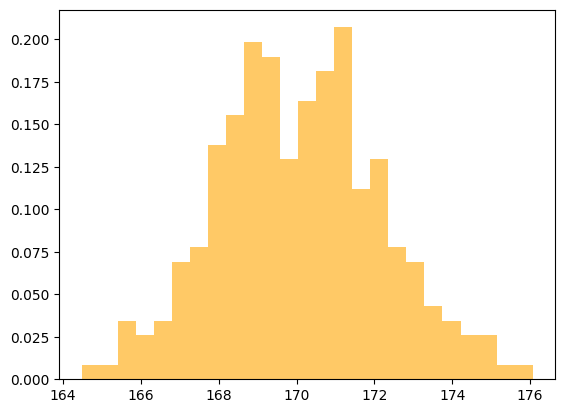

In [2]:
import numpy as np
import matplotlib.pyplot as plt
  
# Generating some random data
# for an example
data = np.random.normal(loc=170, scale=2, size=250)
  
# Plotting the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='orange')
  
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import seaborn as sns

data_out = []

for _ in range(7):
    data = []
    for _ in range(7):
        value = randint(1, 5)
        data.append(value)
    data_out.append(data)
data_out

[[1, 1, 5, 1, 4, 1, 4],
 [3, 1, 4, 5, 2, 2, 4],
 [3, 1, 1, 3, 4, 2, 4],
 [4, 2, 2, 2, 5, 3, 5],
 [1, 5, 4, 4, 2, 4, 3],
 [3, 1, 4, 1, 4, 5, 1],
 [4, 1, 5, 2, 2, 2, 2]]

<AxesSubplot: >

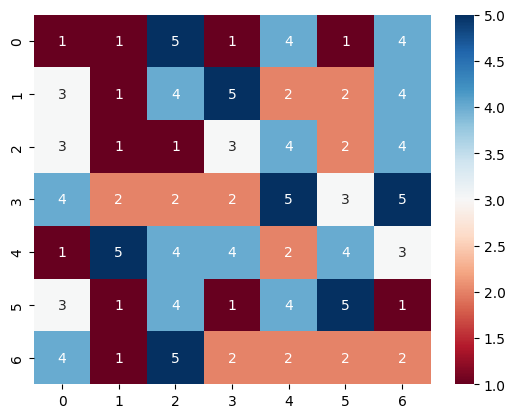

In [4]:
df = pd.DataFrame(data_out)
sns.heatmap(df, annot=True, cmap="RdBu")

<AxesSubplot: >

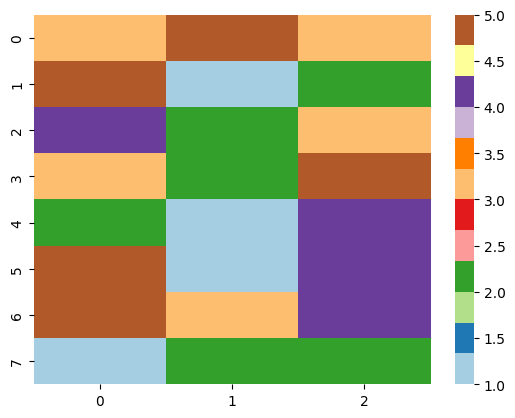

In [5]:
data_out = []
for _ in range(8):
    data = []
    for _ in range(3):
        value = randint(1, 5)
        data.append(value)
    data_out.append(data)
data_out

df = pd.DataFrame(data_out)
sns.heatmap(df, annot=False, cmap=sns.color_palette("Paired"))

In [6]:
df.append(df) 

/var/folders/km/l90xp47s19v3fplyb1b0bc480000gp/T/ipykernel_56848/371108743.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(df)


,0,1,2
0,3,5,3
1,5,1,2
2,4,2,3
3,3,2,5
4,2,1,4
5,5,1,4
6,5,3,4
7,1,2,2
0,3,5,3
1,5,1,2


In [7]:
temp_data = pd.read_csv("../../Data/PyRads_CHUM.csv")

In [8]:
temp_data.rename(columns=dict(zip(temp_data.columns, range(len(temp_data.columns))))).round(2).head(10)

,0,1,2,3,4,5,6,7,8,9,...,843,844,845,846,847,848,849,850,851,852
0,1,002-CHUM,0.71,0.24,26.61,110.53,99.20,99.20,130.23,132.61,...,3481.33,592.71,7098.31,8.77,54470.30,0.00,0.00,0.43,3450.33,0.00
1,2,003-CHUM,0.59,0.17,5.21,30.21,22.09,28.44,31.06,31.92,...,6.27,403.18,770.18,1.81,1337.89,0.03,0.02,0.81,629.09,0.02
2,3,004-CHUM,0.72,0.19,7.75,41.25,32.02,36.12,42.44,45.71,...,17.89,388.44,2035.41,2.80,7829.89,0.00,0.00,0.72,1329.53,0.00
3,4,005-CHUM,0.81,0.12,9.42,79.53,70.58,76.16,83.55,97.80,...,163.49,591.23,5796.66,4.32,27468.89,0.00,0.00,0.63,3489.55,0.00
4,5,006-CHUM,0.96,0.36,15.78,43.50,40.85,40.85,53.04,55.12,...,462.23,147.92,5115.13,4.72,24494.93,0.00,0.00,0.54,2715.62,0.00
5,6,007-CHUM,0.95,0.22,13.12,60.00,54.12,54.12,72.84,74.36,...,942.49,149.04,4266.47,9.33,41475.32,0.00,0.00,0.40,1568.79,0.00
6,7,009-CHUM,0.13,0.07,2.81,37.88,7.00,11.00,24.41,38.21,...,4.06,393.69,2239.16,1.77,4088.75,0.01,0.01,0.84,1822.53,0.01
7,8,010-CHUM,0.81,0.18,24.22,131.97,118.66,118.46,151.49,163.86,...,1100.30,169.74,5203.52,2.75,14677.60,0.00,0.00,0.69,3547.57,0.00
8,9,011-CHUM,0.45,0.30,9.64,31.95,20.12,29.41,32.25,33.48,...,69.62,322.61,5021.43,7.23,33737.18,0.00,0.00,0.51,2701.65,0.00
9,10,012-CHUM,0.72,0.25,14.85,60.40,66.22,58.05,74.95,78.03,...,458.19,287.65,3246.59,11.54,52200.77,0.00,0.00,0.47,1140.37,0.00


In [9]:
# random fit plot
data_out = []
for _ in range(50):
    data = []
    for _ in range(2):
        value = randint(0,200)
        data.append(value)
    data_out.append(data)
df = pd.DataFrame(data=data_out, columns= ["x", "y"])


In [10]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

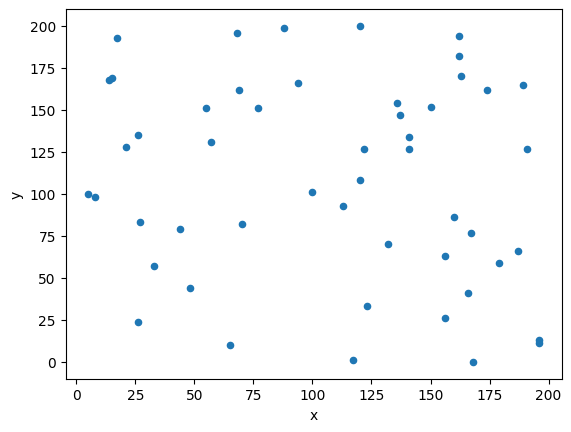

In [11]:
df.plot.scatter(x="x", y="y")
plt.show()


In [12]:
def objective(x, a, b, c):
 return a * x^2 + b
popt, _ = curve_fit(objective, x_values, y_values)

NameError: name 'curve_fit' is not defined

y = 0.22894 * x + -128.64474


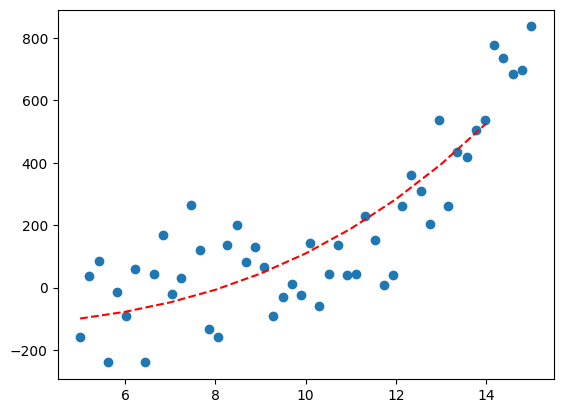

In [13]:
# fit a straight line to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c):
 return a * x**2 *c*x + b

# choose the input and output variables
#x, y = df["x"], df["y"]
def exponential(x, a, b):
    return a*np.exp(b*x)
    
x_dummy = np.linspace(start=5, stop=15, num=50)
# Calculate y-values based on dummy x-values
y_dummy = exponential(x_dummy, 0.5, 0.5)
# Add noise from a Gaussian distribution
noise = 100*np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise
x= x_dummy
y=y_dummy

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f' % (a, b))
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

In [14]:
import random

In [15]:
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)
    
x_dummy = np.linspace(start=5, stop=15, num=50)
# Calculate y-values based on dummy x-values
y_dummy = exponential(x_dummy, 0.5, 0.5)
# Add noise from a Gaussian distribution
noise = 100*np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

In [16]:
popt, _ = curve_fit(exponential, x_dummy, y_dummy)


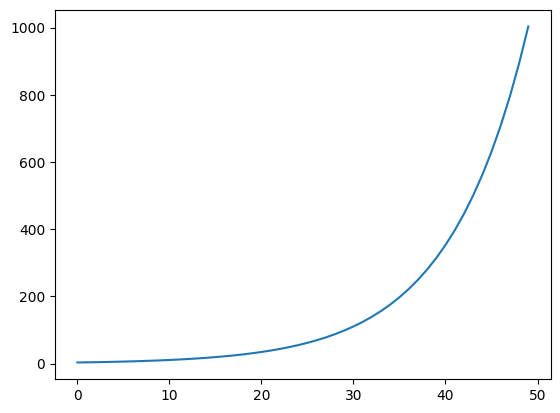

In [17]:
a, b = popt
plt.plot(exponential(x_dummy, a, b))
plt.show()

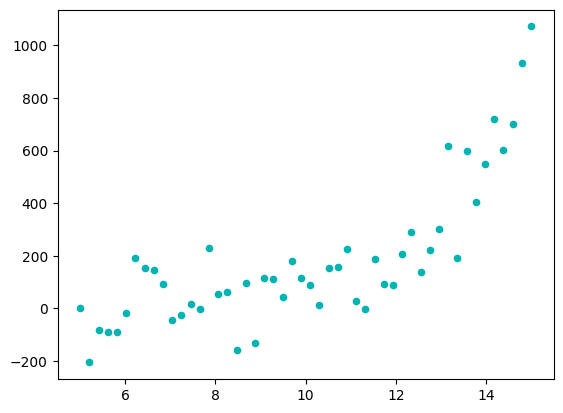

In [20]:
# Plot the noisy exponential data
plt.scatter(x_dummy, y_dummy, s=20, color='#00b3b3', label='Data')
plt.show()

## Step function

In [62]:
# random fit plot
data_out = []
for _ in range(10):
    data = []
    for _ in range(2):
        value = randint(0,15)
        data.append(value)
    data_out.append(data)
df = pd.DataFrame(data=data_out, columns= ["x", "y"])
x_dummy, y_dummy = np.array(df.x), np.array(df.y)
noise = 100*np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

In [63]:
y_dummy[::-1].sort()

In [64]:
y_dummy

array([232.06383133, 124.63502301, 123.39606269,  88.08027882,
        50.08246282,  43.92195004,  31.84239587,  27.63492946,
       -31.75894354, -52.89274923])

(10,)


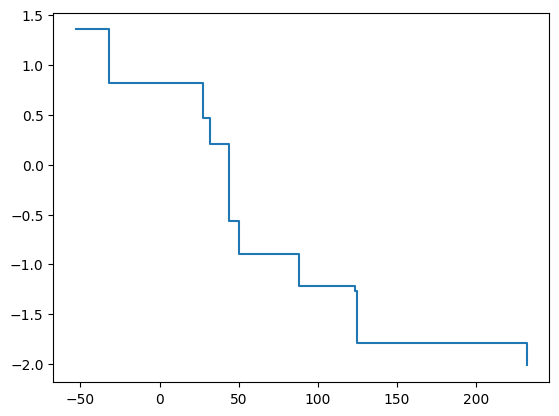

In [65]:
b = np.random.randn(*y_dummy.shape)
b.sort()
print(b.shape)
plt.step(y_dummy, b)
plt.show()

(50,)
